CLASSIFICAZIONE DI FRUTTI ESOTICI CON ALGORITMO K-NEAREST NEIGHBORS

AUTORE: ROSA SANTELIA

In [91]:
# Importazione moduli e librerie

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
# Definizione costanti

RANDOM_SEED=5

In [92]:
# Caricamento e preprocessamento dei dati sui frutti esotici

url = 'https://proai-datasets.s3.eu-west-3.amazonaws.com/fruits.csv'
df = pd.read_csv(url)
df.head()

,Frutto,Peso (g),Diametro medio (mm),Lunghezza media (mm),Durezza buccia (1-10),Dolcezza (1-10)
0,Mela,86.40,89.68,8.69,9.61,2.41
1,Mela,77.58,73.45,6.49,7.20,3.87
2,Mela,81.95,81.66,6.40,9.09,2.88
3,Mela,66.33,36.71,6.78,8.21,2.55
4,Mela,56.73,75.69,5.78,9.15,3.88


In [93]:
# Gestione dei valori mancanti, codifica delle variabili categoriche e normalizzazione/scalatura dei dati

df.shape

(500, 6)

In [94]:
# Visualizzo le informazioni sul DataFrame che presenta 500 samples e 6 features, di cui una target

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Frutto                 500 non-null    object 
 1   Peso (g)               500 non-null    float64
 2   Diametro medio (mm)    500 non-null    float64
 3   Lunghezza media (mm)   500 non-null    float64
 4   Durezza buccia (1-10)  500 non-null    float64
 5   Dolcezza (1-10)        500 non-null    float64
dtypes: float64(5), object(1)
memory usage: 23.6+ KB


In [95]:
# Visualizzo una panoramica delle principali metriche statistiche

df.describe()

,Peso (g),Diametro medio (mm),Lunghezza media (mm),Durezza buccia (1-10),Dolcezza (1-10)
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,47.313440,86.573100,5.298620,7.437640,3.593220
std,26.768797,64.293403,2.641993,1.812548,1.264899
min,8.570000,7.530000,1.150000,3.070000,1.250000
25%,24.797500,50.510000,2.672500,6.152500,2.570000
50%,42.380000,70.450000,5.670000,7.340000,3.535000
75%,68.080000,88.852500,7.455000,8.615000,4.465000
max,111.210000,299.890000,11.140000,13.720000,6.950000


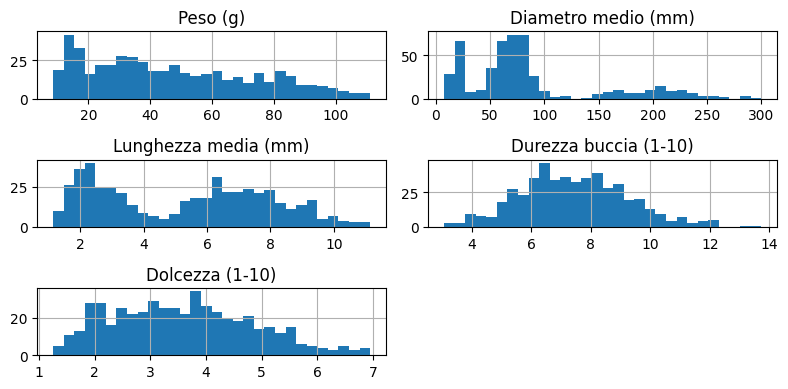

In [96]:
df.iloc[:, 1:].hist(bins=30, figsize=(8, 4))
plt.tight_layout()
plt.show()

In [97]:
# Le features Peso e Diametro Medio presentano un'elevata deviazione standard e pertanto una maggiore dispersione dei dati dai valori medi
# I valori della mediana (tranne che per la variabile Diametro medio) indicano una distribuzione dei dati abbastanza simmetrica
# Il grafico mostra una distribuzione bimodale per la variabile Lunghezza media

In [98]:
df.isna().sum()

,0
Frutto,0
Peso (g),0
Diametro medio (mm),0
Lunghezza media (mm),0
Durezza buccia (1-10),0
Dolcezza (1-10),0


In [99]:
# Esploro quali valori può contenere la colonna target "Frutto"

df["Frutto"].unique()

array(['Mela', 'Banana', 'Arancia', 'Uva', 'Kiwi'], dtype=object)

In [100]:
df['Frutto'].value_counts()

,count
Frutto,
Mela,100
Banana,100
Arancia,100
Uva,100
Kiwi,100


In [101]:
# Il dataset risulta perfettamente bilanciato in termini di variabile target

In [102]:
# Verifico l'eventuale presenza di valori ripetuti

df.duplicated().sum()

np.int64(0)

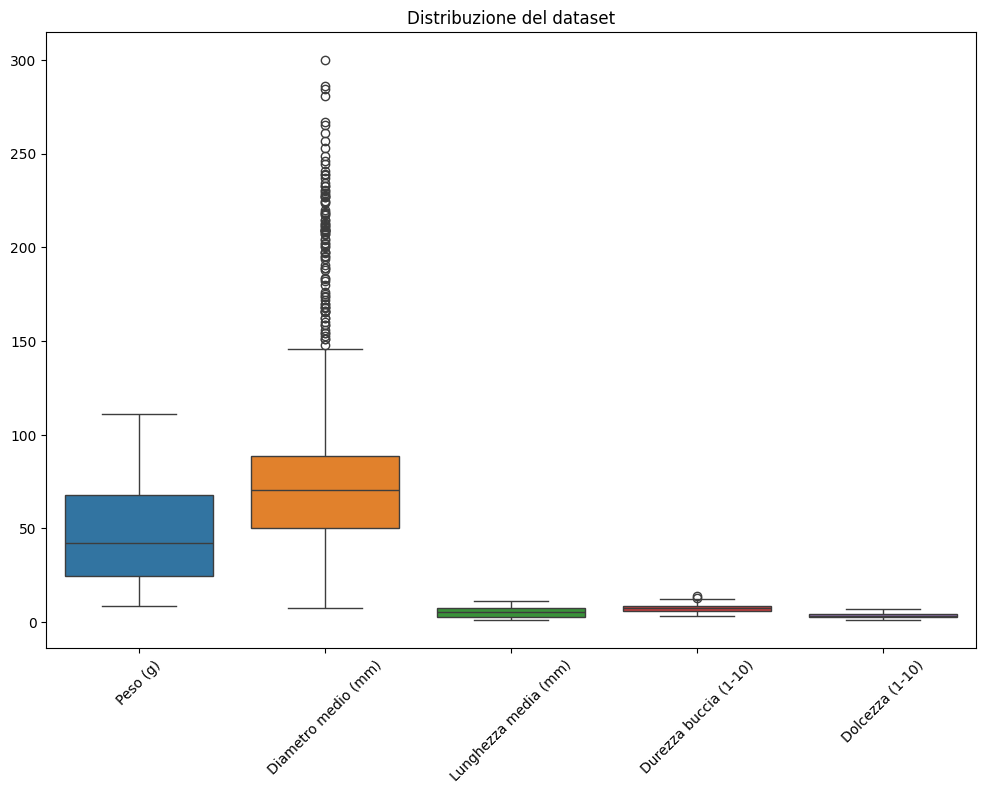

In [103]:
# Verifico la presenza di outlier tramite un boxplot

plt.figure(figsize=(12,8))
sns.boxplot(data=df)
plt.xticks(rotation=45)
plt.title("Distribuzione del dataset")
plt.show()

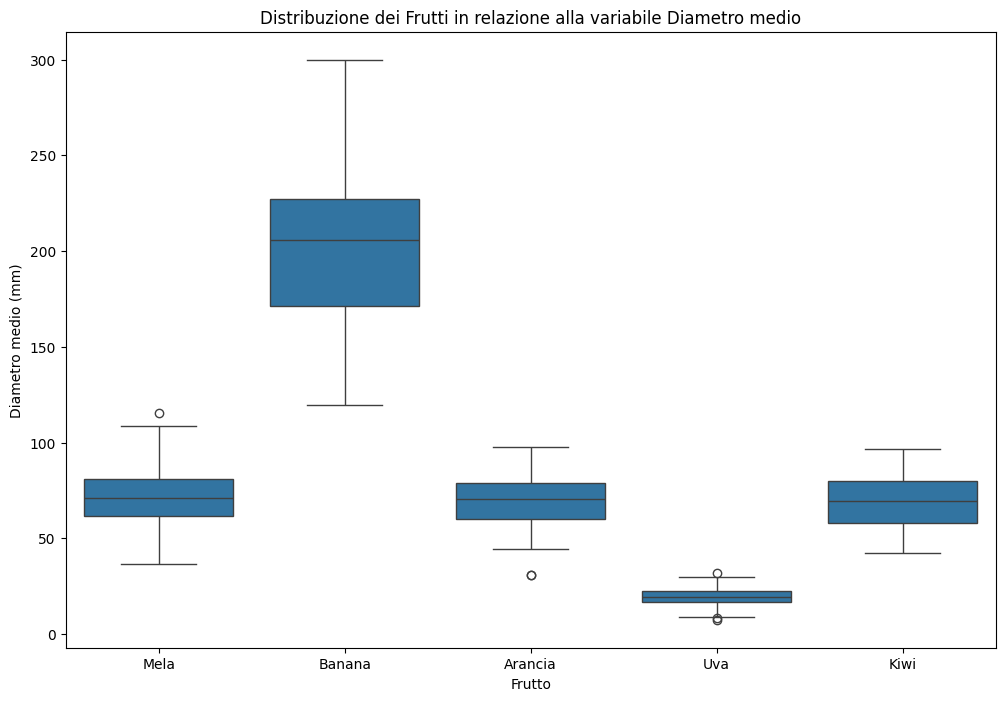

In [104]:
plt.figure(figsize=(12, 8))
sns.boxplot(
    x=df['Frutto'],
    y=df['Diametro medio (mm)'],
)
plt.title("Distribuzione dei Frutti in relazione alla variabile Diametro medio")
plt.xlabel("Frutto")
plt.ylabel("Diametro medio (mm)")
plt.show()

In [106]:
# Procedo a trasformare la variabile target di tipo stringa in una numerica

encoder = LabelEncoder()
df["Frutto"] = encoder.fit_transform(df["Frutto"])
df.head()


,Frutto,Peso (g),Diametro medio (mm),Lunghezza media (mm),Durezza buccia (1-10),Dolcezza (1-10)
0,3,86.40,89.68,8.69,9.61,2.41
1,3,77.58,73.45,6.49,7.20,3.87
2,3,81.95,81.66,6.40,9.09,2.88
3,3,66.33,36.71,6.78,8.21,2.55
4,3,56.73,75.69,5.78,9.15,3.88


In [107]:
# Creo anche il relativo dizionario

mapping = {
    0: 'Mela',
    1: 'Banana',
    2: 'Arancia',
    3: 'Uva',
    4: 'Kiwi'
}

In [108]:
# Le variabili non target risultano tutte numeriche e pertanto non si necessita di effettuare Feature Encoding

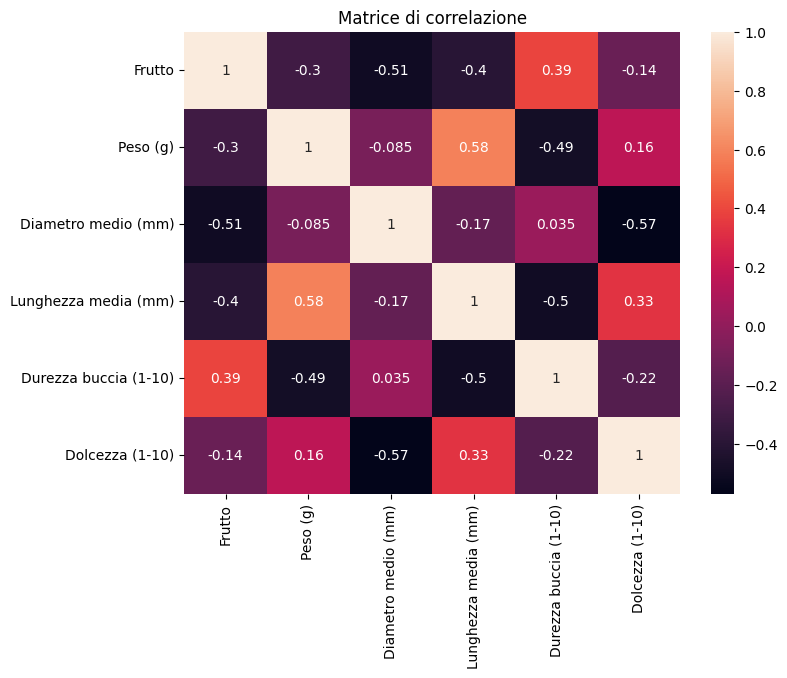

In [109]:
# Verifico la correlazione delle variabili tramite Matrice di Correlazione

plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), cbar=True, annot=True)
plt.title("Matrice di correlazione")
plt.show()

In [110]:
# La feature più correlata con la variabile target risulta essere il Diametro medio (-0.51 > correlazione negativa).
# Seguono, a poca distanza, la Lunghezza media (-0.4 > correlazione negativa) e la Durezza Buccia (0.39 > correlazione positiva)

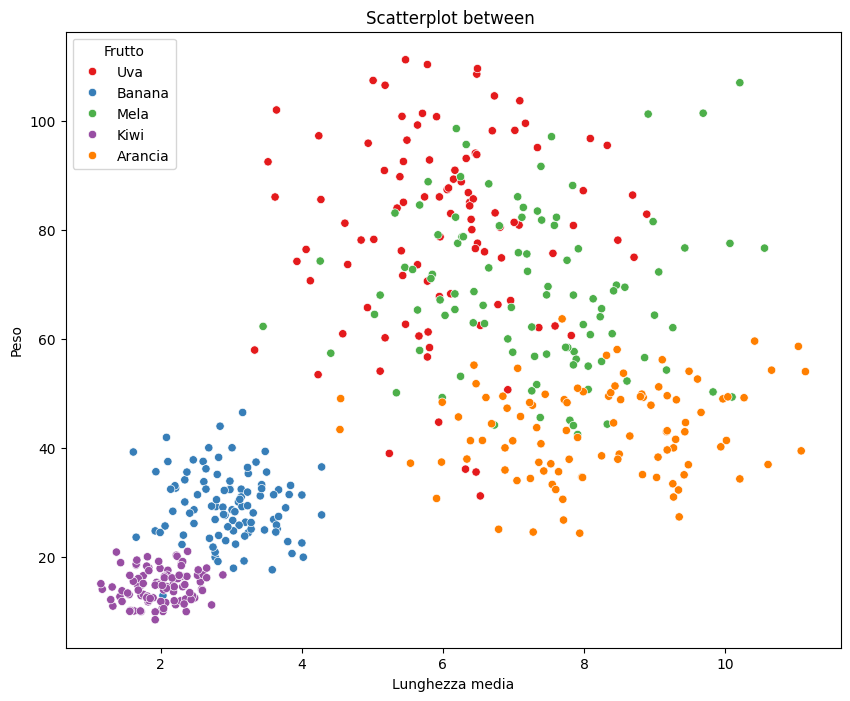

In [111]:
# Visualizzo il grafico per le features non target con maggiore correlazione positiva

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=df['Lunghezza media (mm)'], y=df['Peso (g)'],
    hue=df['Frutto'].map(mapping), palette="Set1")
plt.title(f'Scatterplot between ')
plt.xlabel('Lunghezza media')
plt.ylabel('Peso')
plt.show()

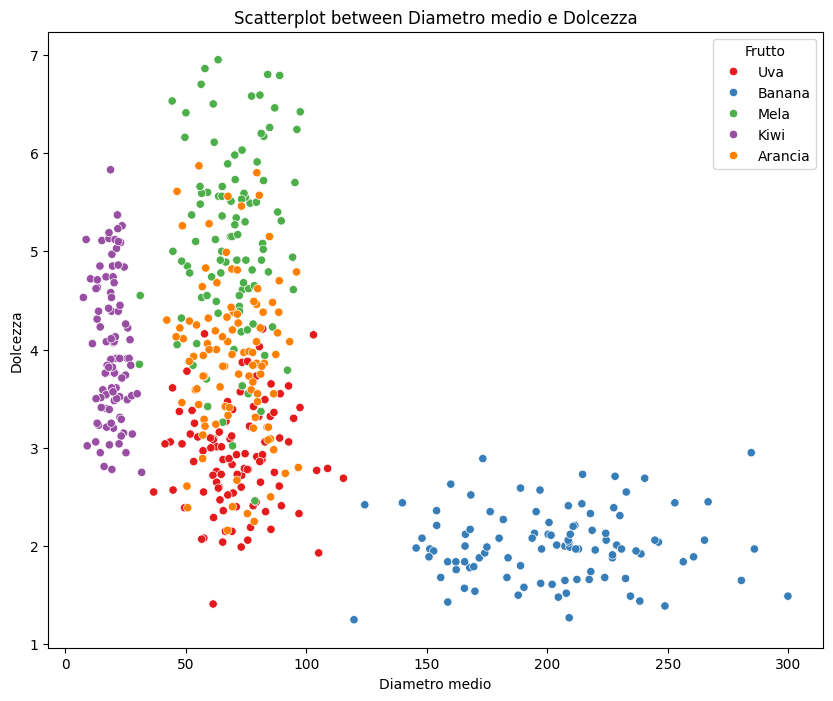

In [112]:
# Visualizzo il grafico per le features non target con maggiore correlazione negativa

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=df['Diametro medio (mm)'], y=df['Dolcezza (1-10)'],
    hue=df['Frutto'].map(mapping), palette="Set1")
plt.title(f'Scatterplot between Diametro medio e Dolcezza')
plt.xlabel('Diametro medio')
plt.ylabel('Dolcezza')
plt.show()

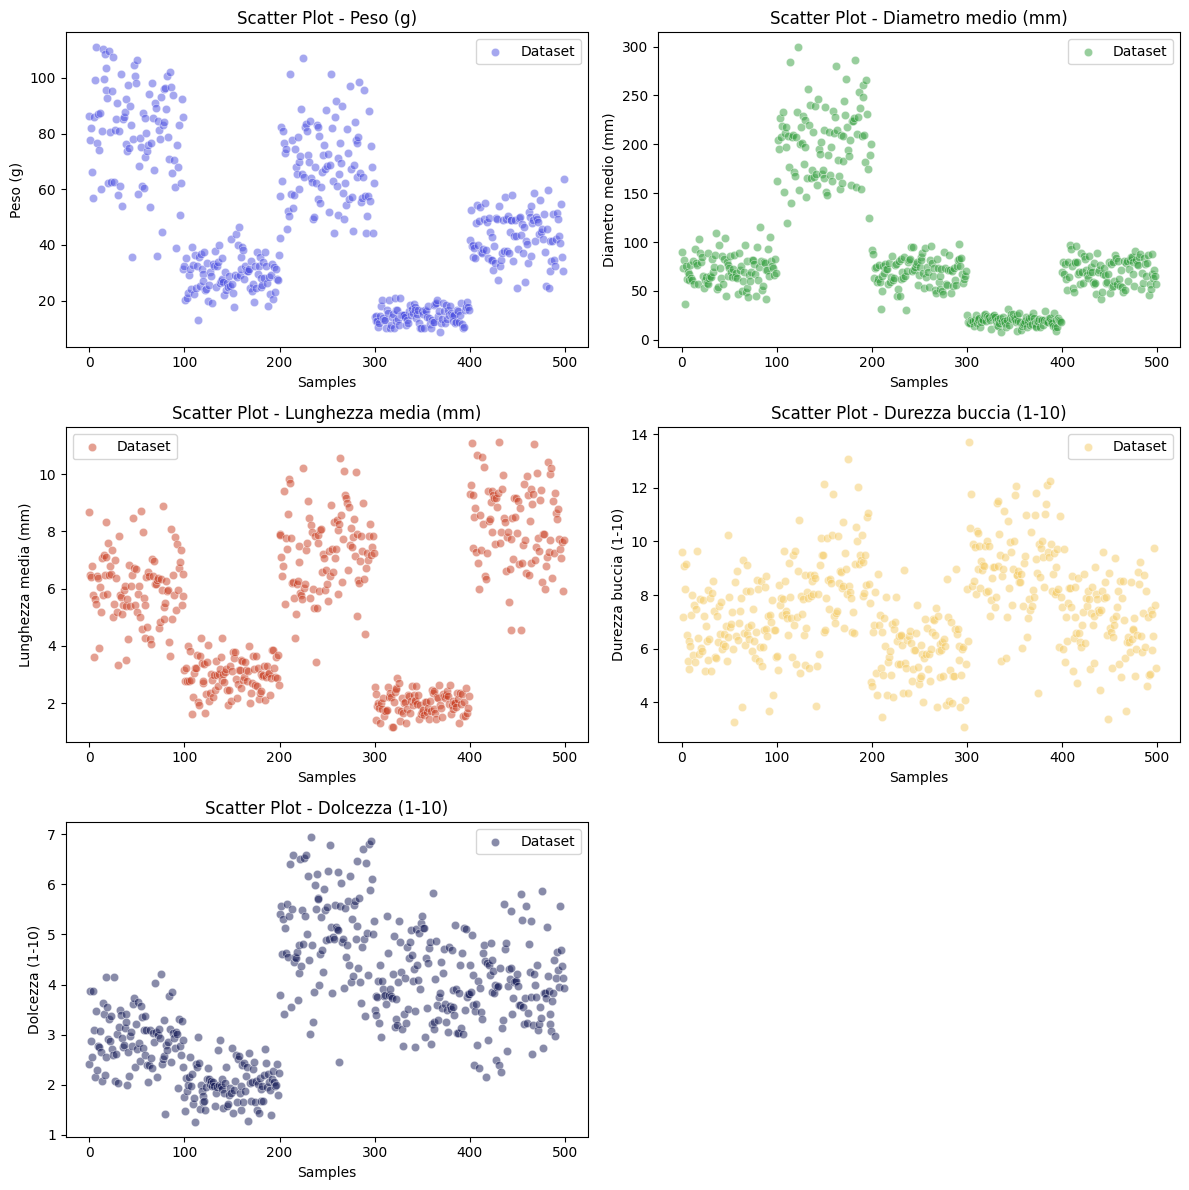

In [115]:
# Passo alla visualizzazione grafica dei campioni nel dataset per ciascuna delle features

def scatterplot_series (ax, col_name, color):
  sns.scatterplot(y=df[col_name], x=range(len(df)), ax=ax, color=color, alpha=0.5, label = "Dataset")
  ax.set_title(f"Scatter Plot - {col_name}")
  ax.set_xlabel("Samples")
  ax.set_ylabel(col_name)
  ax.legend()


num_col = df.shape[1]-1
num_righe = (num_col//2) + (num_col%2)

fig, axes = plt.subplots(nrows=num_righe, ncols=2, figsize=(12, num_righe*4))

for i, col_name in enumerate(df.drop("Frutto", axis=1).columns):
  row, col = i // 2, i % 2
  scatterplot_series(axes[row, col], col_name, "#{:06x}".format(random.randint(0, 0xFFFFFF)))

for j in range(i+1, num_righe*2):
  fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

In [116]:
# Le variabili hanno scale molto diverse e quindi si rende necessario scalarle per portarle ad una scala comune. Non risultano, inoltre, presenti valori mancanti

mms = MinMaxScaler()

In [117]:
# Procedo alla creazione di un modello utilizzando un algoritmo Nearest Neighbors per andare a separare le 5 classi

In [118]:
# Splitto per prima cosa in dataset di training e di test

X = df.drop("Frutto", axis=1)
y = df["Frutto"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=RANDOM_SEED)

In [119]:
X_train.shape

(400, 5)

In [120]:
X_test.shape

(100, 5)

In [121]:
y_train.shape

(400,)

In [122]:
y_test.shape

(100,)

In [123]:
# Procedo con la cross validation
# Scelgo l'iperparametro K che permetta al modello di performare meglio, testando diversi valori di K andandone a calcolare le metriche selezionate (accuracy e log loss)

Ks =[1, 2, 3, 4, 5, 10, 12, 15, 20, 30, 40, 50, 100]

for K in Ks:

  print(f"K={K}")

  knn = KNeighborsClassifier(n_neighbors=K)
  knn.fit(X_train, y_train)

  y_pred_train = knn.predict(X_train)
  y_proba_train = knn.predict_proba(X_train)

  y_pred_test = knn.predict(X_test)
  y_proba_test = knn.predict_proba(X_test)

  accuracy_train = accuracy_score(y_train, y_pred_train)
  accuracy_test = accuracy_score(y_test, y_pred_test)

  log_train = log_loss(y_train, y_proba_train)
  log_test = log_loss(y_test, y_proba_test)

  print(f"ACCURACY: TRAIN={accuracy_train:.3f} TEST= {accuracy_test:.3f}")
  print(f"LOG LOSS: TRAIN={log_train:.4f} TEST= {log_test:.4f}")

K=1
ACCURACY: TRAIN=1.000 TEST= 0.860
LOG LOSS: TRAIN=0.0000 TEST= 5.0461
K=2
ACCURACY: TRAIN=0.892 TEST= 0.850
LOG LOSS: TRAIN=0.1490 TEST= 3.7222
K=3
ACCURACY: TRAIN=0.907 TEST= 0.810
LOG LOSS: TRAIN=0.1975 TEST= 2.7336
K=4
ACCURACY: TRAIN=0.873 TEST= 0.800
LOG LOSS: TRAIN=0.2340 TEST= 2.0602
K=5
ACCURACY: TRAIN=0.887 TEST= 0.800
LOG LOSS: TRAIN=0.2620 TEST= 1.7353
K=10
ACCURACY: TRAIN=0.830 TEST= 0.840
LOG LOSS: TRAIN=0.3308 TEST= 1.0735
K=12
ACCURACY: TRAIN=0.825 TEST= 0.800
LOG LOSS: TRAIN=0.3413 TEST= 1.0729
K=15
ACCURACY: TRAIN=0.828 TEST= 0.830
LOG LOSS: TRAIN=0.3557 TEST= 1.0678
K=20
ACCURACY: TRAIN=0.830 TEST= 0.820
LOG LOSS: TRAIN=0.3679 TEST= 0.7448
K=30
ACCURACY: TRAIN=0.815 TEST= 0.850
LOG LOSS: TRAIN=0.3967 TEST= 0.7295
K=40
ACCURACY: TRAIN=0.818 TEST= 0.820
LOG LOSS: TRAIN=0.4087 TEST= 0.4322
K=50
ACCURACY: TRAIN=0.815 TEST= 0.850
LOG LOSS: TRAIN=0.4154 TEST= 0.4404
K=100
ACCURACY: TRAIN=0.810 TEST= 0.830
LOG LOSS: TRAIN=0.5504 TEST= 0.5759


In [124]:
# Con un valore di K=1 andiamo in overfitting. Il modello memorizza i dati di training e fallisce completamente a generalizzare
# Con l’aumentare di K, l’accuracy sul set di train diminuisce (meno overfitting)
# Anche il valore della Log loss diminuisce fino a K=40–50
# L'Accuracy test si mantiene buona (0.83–0.85) per K = 10–50, quindi in quel range il modello risulta abbastanza stabile
# Valori di K compresi tra 30 e 50 rappresentano un ottimo compromesso tra accuratezza e log loss sul test set, con buona generalizzazione e bassa incertezza predittiva

In [125]:
# Applico anche la Cross Validation con il metodo GridSearchCV (escludendo il valore 1 che porterebbe all'overfitting)

param_grid = {'n_neighbors': list(range(2, 101))}
grid_search = GridSearchCV(knn, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Miglior K trovato:", grid_search.best_params_['n_neighbors'])
print("Miglior accuratezza:", grid_search.best_score_)

X = df.drop("Frutto", axis=1)
y = df["Frutto"]
grid_search

Miglior K trovato: 31
Miglior accuratezza: 0.8225


GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=100),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                         24, 25, 26, 27, 28, 29, 30, 31, ...]},
             scoring='accuracy')

In [126]:
# Riaddestro quindi il modello con il K risultante dalla cross validation con metodo GridSearchCV (K=31), considerando quindi i 31 vicini più prossimi (neighbors)

knn = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'], weights='uniform')
knn.fit(X_train, y_train)

score = knn.score(X_test, y_test)
print(f"Score: {score:.2f}")

y_pred = knn.predict(X_test)
print("Valutazione:")
print(classification_report(y_pred_test, y_test))

Score: 0.85
Valutazione:
              precision    recall  f1-score   support

           0       0.62      0.72      0.67        18
           1       0.96      1.00      0.98        22
           2       0.92      0.76      0.83        29
           3       0.60      0.64      0.62        14
           4       1.00      1.00      1.00        17

    accuracy                           0.83       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.84      0.83      0.83       100



In [127]:
error_rate = 1 - score
print(f"Errore di classificazione: {error_rate:.2f}")

Errore di classificazione: 0.15


Text(50.722222222222214, 0.5, 'Valore Reale')

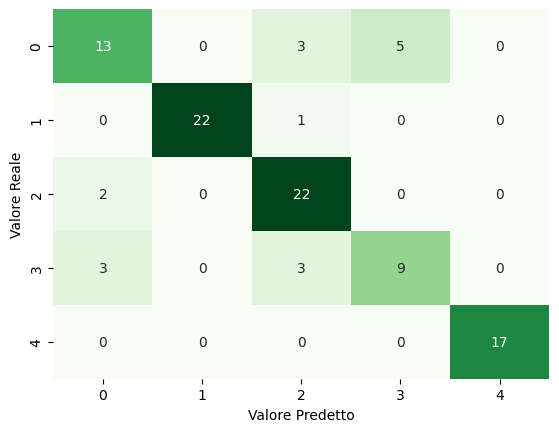

In [128]:
# Utilizzo la matrice di confusione per valutare eventuali aree di miglioramento

cm = confusion_matrix(y_test, y_pred_test)
df_cm = pd.DataFrame(cm, index=encoder.classes_, columns=encoder.classes_)
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.xlabel('Valore Predetto')
plt.ylabel('Valore Reale')

In [65]:
# 3 istanze della classe Arancia sono state erroneamente classificate come Kiwi e 5 come Mela
# 1 istanza della classe Banana è stata erroneamente classificata come Kiwi
# 2 istanze della classe Kiwi sono state erroneamente classificate come Arancia
# 3 istanze della classe Mela sono state erroneamente classificate come Arancia e 3 come Kiwi
# Il modello si comporta perfettamente per l'Uva, senza errori di classificazione

# In sintesi:

# Il modello dimostra una forte performance per Banana, Kiwi e Uva, con l'Uva classificata perfettamente
# Presenta confusione per Arancia e Mela

In [129]:
# Tento di migliorare il modello

# Creo un dataframe con i valori reali e predetti per le classi più problematiche (Arancia: 2 e Mela: 0)

df_test = pd.DataFrame({'Valore Reale': y_test, 'Valore Predetto': y_pred_test})

# Seleziono solo gli errori della classe 0 e 2

errori_classe_0 = df_test[(df_test['Valore Reale'] == 0) & (df_test['Valore Predetto'] != 0)]
errori_classe_2 = df_test[(df_test['Valore Reale'] == 2) & (df_test['Valore Predetto'] != 2)]

print("Errori della classe Mela:\n", errori_classe_0)
print("\n")
print("Errori della classe Arancia:\n", errori_classe_2)

Errori della classe Mela:
      Valore Reale  Valore Predetto
241             0                3
280             0                3
242             0                3
223             0                3
219             0                3
298             0                2
292             0                2
201             0                2


Errori della classe Arancia:
      Valore Reale  Valore Predetto
474             2                0
445             2                0


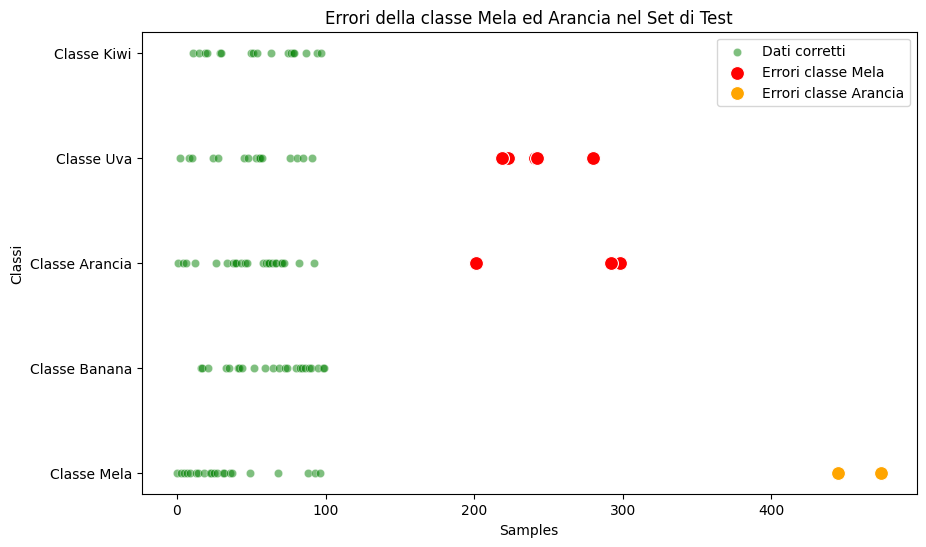

In [130]:
# Visualizzo con uno scatterplot gli errori per le due classi

plt.figure(figsize=(10,6))

sns.scatterplot(x=range(len(y_test)), y=y_test, color="green", label="Dati corretti", alpha=.5)

sns.scatterplot(x=errori_classe_0.index, y=errori_classe_0["Valore Predetto"], color="red", label="Errori classe Mela", s=100)

sns.scatterplot(x=errori_classe_2.index, y=errori_classe_2["Valore Predetto"], color="orange", label="Errori classe Arancia", s=100)

plt.yticks([0,1,2,3,4], labels=["Classe Mela", "Classe Banana", "Classe Arancia", "Classe Uva", "Classe Kiwi"])

plt.xlabel("Samples")
plt.ylabel("Classi")
plt.title("Errori della classe Mela ed Arancia nel Set di Test")
plt.legend()
plt.show()

In [131]:
# Provo a riaddestrare il modello usando StandardScaler invece che MinMaxScaler

sc = StandardScaler()
X_scaled = sc.fit_transform(X)

knn = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'], weights='uniform')
knn.fit(X_train, y_train)

score = knn.score(X_test, y_test)
print(f"Score: {score:.2f}")

y_pred = knn.predict(X_test)
print("Valutazione:")
print(classification_report(y_pred_test, y_test))


Score: 0.85
Valutazione:
              precision    recall  f1-score   support

           0       0.62      0.72      0.67        18
           1       0.96      1.00      0.98        22
           2       0.92      0.76      0.83        29
           3       0.60      0.64      0.62        14
           4       1.00      1.00      1.00        17

    accuracy                           0.83       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.84      0.83      0.83       100



In [132]:
# Provo ad utilizzare il parametro weights='distance' di modo da dare un peso maggiore ai neighbors più vicini

knn = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'], weights='distance')
knn.fit(X_train, y_train)

score = knn.score(X_test, y_test)
print(f"Score: {score:.2f}")

y_pred = knn.predict(X_test)
print("Valutazione:")
print(classification_report(y_pred_test, y_test))

Score: 0.85
Valutazione:
              precision    recall  f1-score   support

           0       0.62      0.72      0.67        18
           1       0.96      1.00      0.98        22
           2       0.92      0.76      0.83        29
           3       0.60      0.64      0.62        14
           4       1.00      1.00      1.00        17

    accuracy                           0.83       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.84      0.83      0.83       100



In [133]:
# Effettuo un check sulla distribuzione delle classi nel set di test

print("\nDistribuzione nel Set di Test:\n", y_test.value_counts())


Distribuzione nel Set di Test:
 Frutto
2    24
1    23
0    21
4    17
3    15
Name: count, dtype: int64


In [134]:
# Dato che la distribuzione delle classi nel set di test non è bilanciata, provo a migliorarla

# Effettuo uno split bilanciato del dataset

df_test = X_test.copy()
df_test['Frutto'] = y_test

n_per_class = 15 # Numero di istanze della classe meno numerosa nel set di test

df_test_balanced = (
    df_test.groupby('Frutto', group_keys=False)
    .apply(lambda g: g.sample(n=n_per_class, random_state=42))
)

X_test_balanced = df_test_balanced.drop(columns='Frutto')
y_test_balanced = df_test_balanced['Frutto']

print("Nuova distribuzione nel Set di Test:\n", y_test_balanced.value_counts())

Nuova distribuzione nel Set di Test:
 Frutto
0    15
1    15
2    15
3    15
4    15
Name: count, dtype: int64


<ipython-input-134-1cb2c3144699>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n_per_class, random_state=42))


In [135]:
# La nuova distribuzione delle classi nel dataset illustra un cambiamento nei valori delle metriche di valutazione

score = knn.score(X_test_balanced, y_test_balanced)
print(f"Score: {score:.2f}")
y_pred_test_balanced = knn.predict(X_test_balanced)

y_pred = knn.predict(X_test_balanced)
print("Valutazione:")
print(classification_report(y_pred_test_balanced, y_test_balanced))

Score: 0.85
Valutazione:
              precision    recall  f1-score   support

           0       0.80      0.67      0.73        18
           1       1.00      1.00      1.00        15
           2       0.80      0.80      0.80        15
           3       0.67      0.83      0.74        12
           4       1.00      1.00      1.00        15

    accuracy                           0.85        75
   macro avg       0.85      0.86      0.85        75
weighted avg       0.86      0.85      0.85        75



Text(50.722222222222214, 0.5, 'Valore Reale')

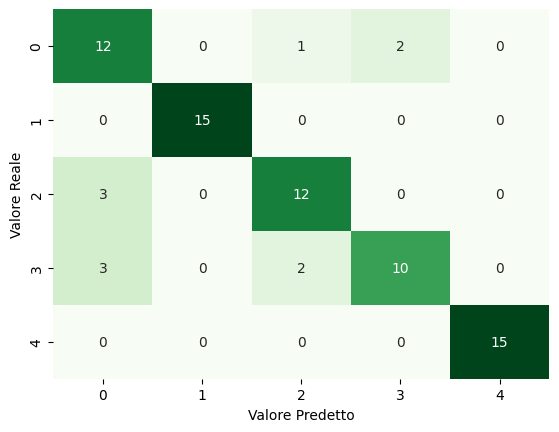

In [136]:
# Andiamo ad approfondire con la matrice di confusione

cm = confusion_matrix(y_test_balanced, y_pred_test_balanced)
df_cm = pd.DataFrame(cm, index=encoder.classes_, columns=encoder.classes_)
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.xlabel('Valore Predetto')
plt.ylabel('Valore Reale')

In [137]:
# Tenendo in considerazione che, con il bilanciamento delle classi, sono diminuiti anche i dati del test di set

# Classe Arancia: diminuisce leggermente la precisione (da 13/21 a 12/15) ma il modello migliora con una riduzione delle misclassificazioni con Kiwi e Mela
# Classe Banana: la precisione assoluta è diminuita (da 22 a 15), ma è stata eliminata la misclassificazione con Kiwi
# Classe Kiwi: diminuzione significativa delle classificazioni corrette (da 22 a 12) e leggero aumento delle misclassificazioni con Arancia, con recall peggiorata (da 22/24 a 12/15)
# Classe Mela: la precisione è leggermente migliorata (da 9/15 a 10/15) e le misclassificazioni con Kiwi sono diminuite
# Classe Uva: la precisione assoluta è diminuita (da 17 a 15), ma la recall rimane perfetta (15/15)

In [138]:
# Creo un nuovo dataframe con i valori reali e predetti

df_test = pd.DataFrame({'Valore Reale': y_test_balanced, 'Valore Predetto': y_pred_test_balanced})

errori_classe_0 = df_test[(df_test['Valore Reale'] == 0) & (df_test['Valore Predetto'] != 0)]
errori_classe_1 = df_test[(df_test['Valore Reale'] == 1) & (df_test['Valore Predetto'] != 1)]
errori_classe_2 = df_test[(df_test['Valore Reale'] == 2) & (df_test['Valore Predetto'] != 2)]
errori_classe_3 = df_test[(df_test['Valore Reale'] == 3) & (df_test['Valore Predetto'] != 3)]
errori_classe_4 = df_test[(df_test['Valore Reale'] == 4) & (df_test['Valore Predetto'] != 4)]

print("Errori della classe Mela:\n", errori_classe_0)
print("\n")
print("Errori della classe Banana:\n", errori_classe_1)
print("\n")
print("Errori della classe Arancia:\n", errori_classe_2)
print("\n")
print("Errori della classe Uva:\n", errori_classe_3)
print("\n")
print("Errori della classe Kiwi:\n", errori_classe_4)

Errori della classe Mela:
      Valore Reale  Valore Predetto
241             0                3
223             0                3
298             0                2


Errori della classe Banana:
 Empty DataFrame
Columns: [Valore Reale, Valore Predetto]
Index: []


Errori della classe Arancia:
      Valore Reale  Valore Predetto
445             2                0
474             2                0
416             2                0


Errori della classe Uva:
     Valore Reale  Valore Predetto
52             3                0
34             3                0
98             3                2
90             3                0
71             3                2


Errori della classe Kiwi:
 Empty DataFrame
Columns: [Valore Reale, Valore Predetto]
Index: []


In [139]:
# Performance per Singola Classe:

# Classe 0 (Arancia):
# Precision: da 0.62 a 0.80 (+0.18) > Miglioramento importante - Recall: da 0.72 a 0.67 (-0.05) > Leggero peggioramento - F1-score: da 0.67 a 0.73 (+0.06) > Miglioramento complessivo

# Classe 1 (Banana):
# Precision: da 0.96 a 1.00 (+0.04) > Piccolo miglioramento che ha portato ad un valore perfetto-  Recall: 1.00 (invariato) > Perfetta -  F1-score: da 0.98 a 1.00 (+0.02) > Miglioramento con raggiungimento del valore perfetto

# Classe 2 (Kiwi):
# Precision: da 0.92 a 0.80 (-0.12) > Significativo peggioramento - Recall: da 0.76 a 0.80 (+0.04) > Leggero miglioramento -  F1-score: da 0.83 a 0.80 (-0.03) > Leggero peggioramento

# Classe 3 (Mela):
# Precision: da 0.60 a 0.67 (+0.07) > Miglioramento -  Recall: da 0.64 a 0.83 (+0.19) > Miglioramento notevole -  F1-score: da 0.62 a 0.74 (+0.12) > Miglioramento significativo

# Classe 4 (Uva):
# Precision: 1.00 (invariato) > Valore perfetto - Recall: 1.00 (invariato) > Valore perfetto - F1-score: 1.00 (invariato) > Valore perfetto

# In sintesi:
# I miglioramenti nelle metriche medie sono particolarmente rilevanti ed indicano una migliore capacità di generalizzazione con un set di test più bilanciato

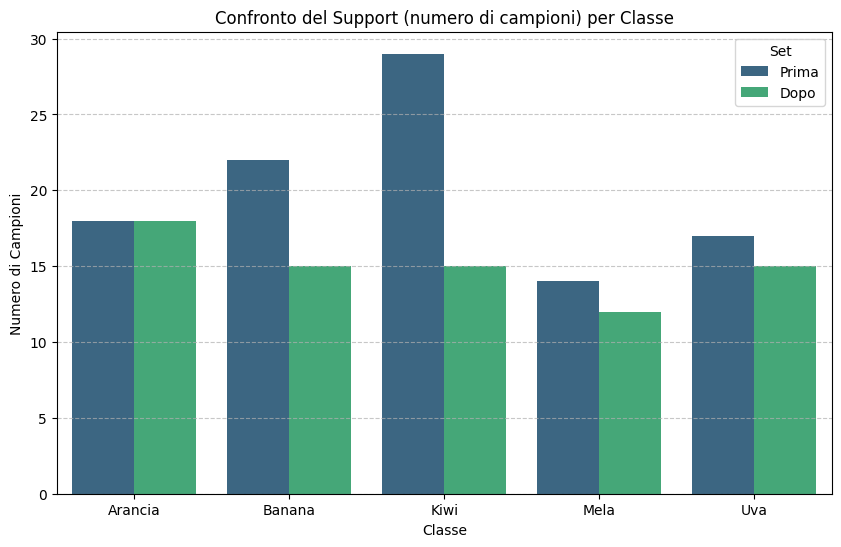

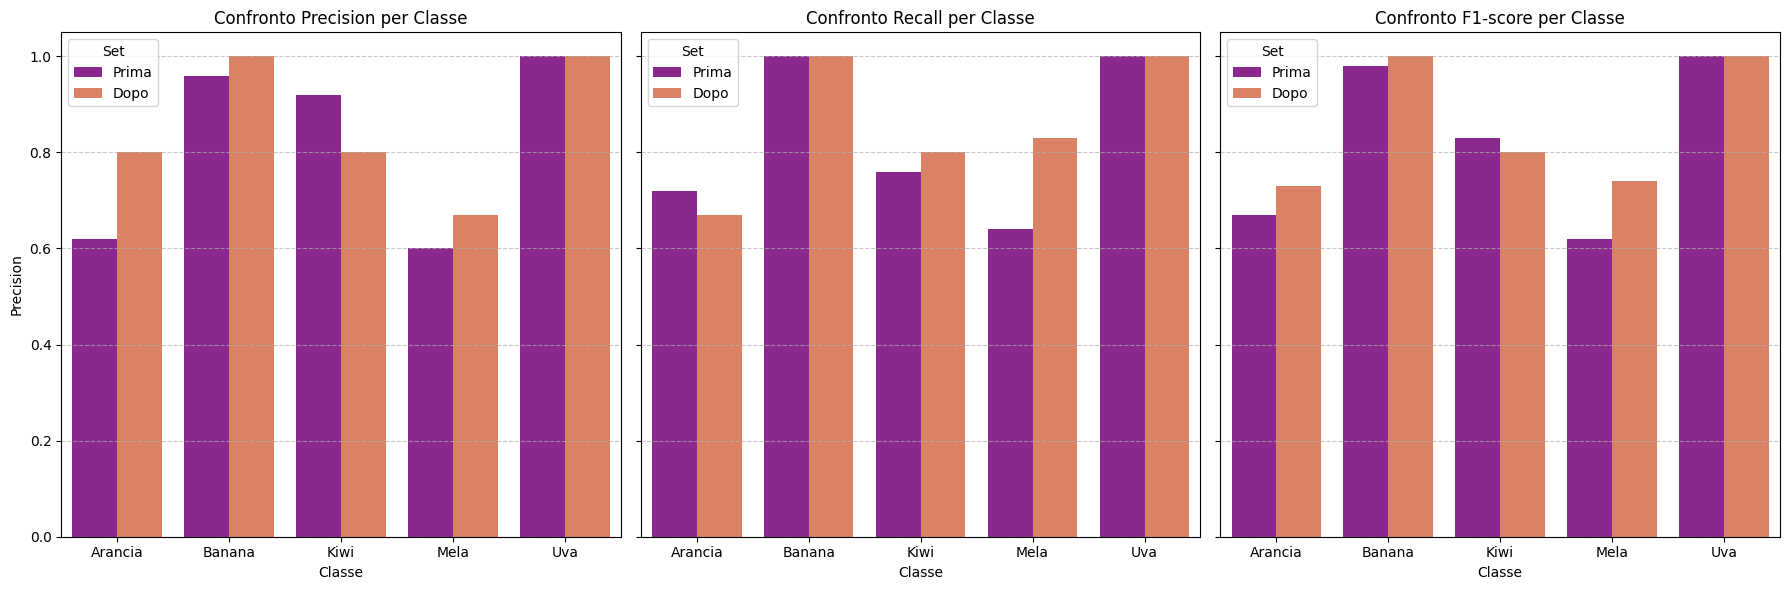

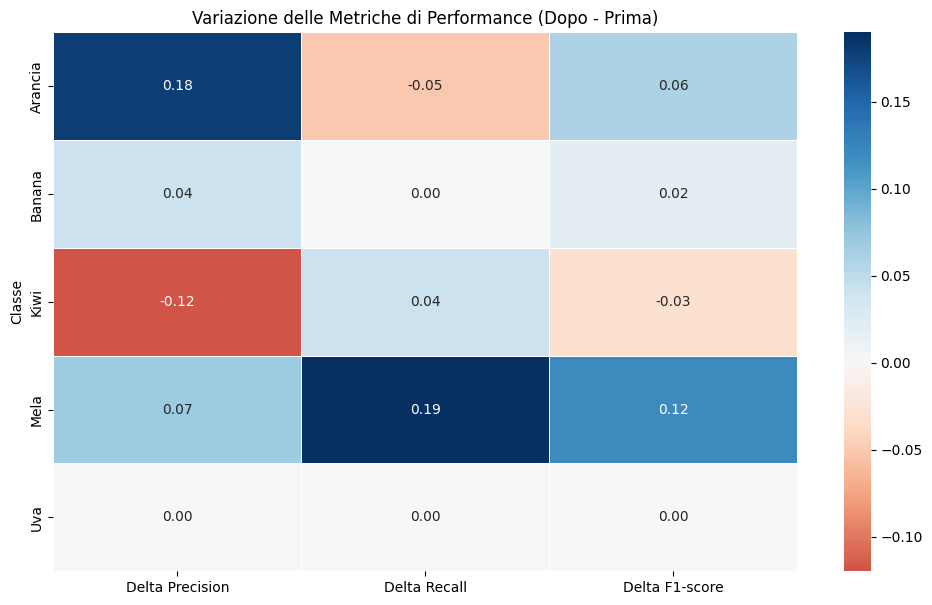

In [146]:
# Visualizzo graficamente le differenze tra il modello pre e post ottimizzazione:

class_labels = ['Arancia', 'Banana', 'Kiwi', 'Mela', 'Uva']

# Dati del test set "Prima" del miglioramento
support_prima = [18, 22, 29, 14, 17]
precision_prima = [0.62, 0.96, 0.92, 0.60, 1.00]
recall_prima = [0.72, 1.00, 0.76, 0.64, 1.00]
f1_prima = [0.67, 0.98, 0.83, 0.62, 1.00]

# Dati del test set "Dopo" il miglioramento
support_dopo = [18, 15, 15, 12, 15]
precision_dopo = [0.80, 1.00, 0.80, 0.67, 1.00]
recall_dopo = [0.67, 1.00, 0.80, 0.83, 1.00]
f1_dopo = [0.73, 1.00, 0.80, 0.74, 1.00]

# Creo un DataFrame per facilitare la visualizzazione con Seaborn
data_prima = pd.DataFrame({
    'Classe': class_labels,
    'Set': 'Prima',
    'Support': support_prima,
    'Precision': precision_prima,
    'Recall': recall_prima,
    'F1-score': f1_prima
})

data_dopo = pd.DataFrame({
    'Classe': class_labels,
    'Set': 'Dopo',
    'Support': support_dopo,
    'Precision': precision_dopo,
    'Recall': recall_dopo,
    'F1-score': f1_dopo
})

# Concateno i due DataFrame
df_combined = pd.concat([data_prima, data_dopo])

# --- Grafico 1: Confronto sul valore del Support (true occorrences) ---
plt.figure(figsize=(10, 6))
sns.barplot(x='Classe', y='Support', hue='Set', data=df_combined, palette='viridis')
plt.title('Confronto del Support (numero di campioni) per Classe')
plt.ylabel('Numero di Campioni')
plt.xlabel('Classe')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
print("\n")

# --- Grafici 2, 3, 4: Confronto delle Metriche (Precision, Recall, F1-score) ---
metrics = ['Precision', 'Recall', 'F1-score']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharey=True)
axes = axes.flatten()

for i, metric in enumerate(metrics):
    sns.barplot(x='Classe', y=metric, hue='Set', data=df_combined, ax=axes[i], palette='plasma')
    axes[i].set_title(f'Confronto {metric} per Classe')
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel('Classe')
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)
    axes[i].set_ylim(0, 1.05)

plt.tight_layout()
plt.show()
print("\n")

# --- Grafico 5: Visualizzazione delle Variazioni ---
# Calcolo le differenze (delta) per evidenziare i cambiamenti
df_diff = pd.DataFrame({
    'Classe': class_labels,
    'Delta Precision': np.array(precision_dopo) - np.array(precision_prima),
    'Delta Recall': np.array(recall_dopo) - np.array(recall_prima),
    'Delta F1-score': np.array(f1_dopo) - np.array(f1_prima)
})

plt.figure(figsize=(12, 7))
sns.heatmap(df_diff.set_index('Classe'), annot=True, cmap='RdBu', fmt=".2f", center=0, linewidths=.5)
plt.title('Variazione delle Metriche di Performance (Dopo - Prima)')
plt.show()